In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pathlib
import os
%matplotlib inline
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.utils.data as torchdata
import fastai


# Fast AI Time Series Competition No1: Earthquakes.

Data is already downloaded in `../data/`. This notebook is mostly exploratory - trying a couple of baseline models.

## Data Loading

In [2]:
data_path = pathlib.Path('../data')

In [3]:
os.listdir(data_path)

['Earthquakes_TEST.txt',
 'Earthquakes.txt',
 'Earthquakes_TRAIN.arff',
 'GADF',
 'Earthquakes_TRAIN.txt',
 'Earthquakes_TEST.arff']

In [4]:
train = np.loadtxt(data_path/'Earthquakes_TRAIN.txt')
test = np.loadtxt(data_path/'Earthquakes_TEST.txt')

In [5]:
train, train_labels = train[:, 1:], train[:, 0].astype(np.int)
test, test_labels = test[:, 1:], test[:, 0].astype(np.int)

We've now nicely numpified our data. Let's try a couple of very simple models.

In [6]:
def test_accuracy(predictions):
    return np.mean(test_labels == predictions)

def pretty_result(result, method):
    print("Accuracy of {0}: {1:.4f}".format(method, result))
    
    
def normalize_features(features):
    train_mean = np.mean(train)
    train_std = np.std(train)
    return (features - train_mean)/train_std

## Constant Models:

In [7]:
pretty_result(test_accuracy(np.ones_like(test_labels)), "all trues")
pretty_result(test_accuracy(np.zeros_like(test_labels)), "all falses")


Accuracy of all trues: 0.2518
Accuracy of all falses: 0.7482


## LSTM-FCNN
This is a reimplementation of the LSTM-FCNN from https://ieeexplore-ieee-org.ezproxy.cul.columbia.edu/ielx7/6287639/8274985/08141873.pdf?tp=&arnumber=8141873&isnumber=8274985&tag=1

The reported accuracy on the Earthquakes dataset in the paper is .8354.

In [32]:
class ShuffleLSTM(nn.Module):
    def __init__(self, seq_length, dropout=0.0, hidden_size=128, num_layers=1, bidirectional=False):
        super().__init__()
        self.lstm = nn.LSTM(input_size=seq_length,
                           hidden_size=hidden_size,
                           num_layers=num_layers,
                           bidirectional=bidirectional)
        self.dropout = nn.Dropout(dropout)
        
    def forward(self, x):
        ## input size will be the seq_len, batch, input_size = 312, 64, 1 
        ## we start with the shuffle layer, transforming this in a 1 step multivariate TS:
        ## output should be 1, 64, 312
        x = torch.transpose(x, 0, 2)
        out, (_, _) = self.lstm(x)
        # after the lstm, the output will be 1, bs, lstm_size
        return self.dropout(out)

In [33]:
class ConvLayer(nn.Module):
    def __init__(self, in_channels=1, n_channels=128, kernel_size=8, dropout=0.0):
        super().__init__()
        self.conv = nn.Conv1d(in_channels=in_channels,
                             out_channels=n_channels,
                             kernel_size=kernel_size)
        self.bn = nn.BatchNorm1d(num_features=n_channels)
        self.dropout = nn.Dropout(dropout)
        
    def forward(self, x):
        # input size should be batch, input_size, length = 64, 1, 312 at first
        x = self.conv(x)
        # now batch, n_channels, L
        x = self.bn(x)
        x = F.relu(x)
        # output will be bs, n_filters, L (not equal to inital L)
        return self.dropout(x)
    

In [34]:
class LSTM_FCNN(nn.Module):
    def __init__(self,
                 seq_length,
                 lstm_dropout=0.0,
                 lstm_hidden_size=128,
                 lstm_num_layers=1,
                 lstm_bidirectional=False,
                 conv_n_channels = [128, 256, 128],
                 conv_kernel_sizes = [8, 5, 3],
                 conv_dropout=0.0):
        
        super().__init__()
        
        self.lstm = ShuffleLSTM(seq_length,
                                lstm_dropout,
                                lstm_hidden_size,
                                lstm_num_layers,
                                lstm_bidirectional)
        self.convs = []
        
        # global pool is avg pool using the last conv layer's size
        self.global_avg_pool = nn.AvgPool1d(kernel_size = conv_n_channels[-1])
        
        # we set input equal to the previous channel's n
        input_n = 1
        for n_c, k_s in zip(conv_n_channels, conv_kernel_sizes):
            conv = ConvLayer(input_n, n_c, k_s, conv_dropout)
            self.convs.append(conv.cuda())
            input_n = n_c
            
        # for the last FC layer, we need to know how long the TS is after 
        # the convolutional layers
        out_len = seq_length - sum(conv_kernel_sizes) + len(conv_kernel_sizes)
        
        self.linear = nn.Linear(out_len + lstm_hidden_size, 1)
        
        
        
    def forward(self, x):
        # our input is batch, seq_len
        x = torch.transpose(x, 0, 1)
        # seq_len, batch
        x = x.unsqueeze(2)
        # seq_len, batch, 1
        
        
        # we need seq_len, batch, input_size = 312, 64, 1
        lstm_out = self.lstm(x)
        lstm_out = torch.squeeze(lstm_out)
        # lstm_out is bs, lstm_size
        
        # we transpose x to be convolutionable:
        x = torch.transpose(x, 0, 1)
        # bs, seq_len, dimension
        x = torch.transpose(x, 1, 2)
        # bs, dimension, seq_len
        for conv_layer in self.convs:
            x = conv_layer(x)
        # x is now bs, dimension, L
        # avgpool1d averages over the last dimension so we transpose again
        x = torch.transpose(x, 1, 2)
        # bs, L, dimension
        x = self.global_avg_pool(x)
        x = torch.squeeze(x)
        # bs, L
        
        concat = torch.cat((lstm_out, x), 1)
        
        return self.linear(concat)


In [35]:
train_ds = torchdata.TensorDataset(
    torch.tensor(train, dtype=torch.float32),
    torch.tensor(train_labels, dtype=torch.float32).unsqueeze(1))
test_ds = torchdata.TensorDataset(
    torch.tensor(test, dtype=torch.float32),
    torch.tensor(test_labels, dtype=torch.float32).unsqueeze(1))

In [36]:
train_dl = torchdata.DataLoader(train_ds, batch_size=32, shuffle=True)
test_dl = torchdata.DataLoader(test_ds, batch_size=32, shuffle=True)

In [37]:
data = fastai.DataBunch(train_dl, test_dl)

In [66]:
model = LSTM_FCNN(512, lstm_dropout=0.9)

In [67]:
loss = nn.BCEWithLogitsLoss()

In [68]:
learner = fastai.Learner(data, model, loss_func=loss)

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


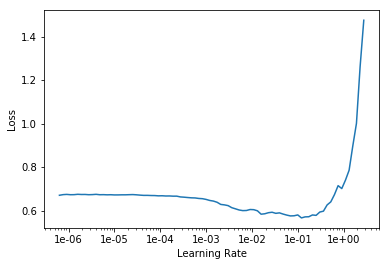

In [69]:
learner.lr_find(); learner.recorder.plot()

In [70]:
learner.fit_one_cycle(10, max_lr=1e-3)

Total time: 00:00
epoch  train_loss  valid_loss
1      0.650414    0.644129    (00:00)
2      0.603748    0.584147    (00:00)
3      0.571739    0.567589    (00:00)
4      0.527135    0.577944    (00:00)
5      0.497058    0.585133    (00:00)
6      0.496856    0.588479    (00:00)
7      0.494808    0.582944    (00:00)
8      0.489002    0.578461    (00:00)
9      0.473444    0.576349    (00:00)
10     0.460708    0.576785    (00:00)



In [ ]:
learner.lr_find(); learner.recorder.plot()

In [62]:

learner.fit_one_cycle(10)

Total time: 00:00
epoch  train_loss  valid_loss
1      0.156135    0.594673    (00:00)
2      0.132428    0.597756    (00:00)
3      0.118791    0.638026    (00:00)
4      0.108471    0.632713    (00:00)
5      0.095182    0.683758    (00:00)
6      0.083774    0.707565    (00:00)
7      0.074956    0.702792    (00:00)
8      0.073051    0.697211    (00:00)
9      0.066901    0.693853    (00:00)
10     0.062391    0.693567    (00:00)

